In [1]:
import numpy as np
import pandas as pd
import json
import os

## Load latest full error (min N for training)

In [2]:
full_err_df = pd.read_csv("Full/full_err.csv", index_col=0)
full_err_df['accumulated_error'] = np.abs(full_err_df['accumulated_error'])
full_err_df = full_err_df.query('N > 100')

## Error dataset sampling (max 1000 by hardware)

In [4]:
# Sample by interval
interval = 1000  # Define the interval for I
sampled_err_df = full_err_df[(full_err_df['I'] % interval == 0) | (full_err_df['I'] == 2)]  # Sample rows where I is a multiple of the interval or equal to 0
print(full_err_df.shape)
print(sampled_err_df.shape)

(800080, 5)
(880, 5)


## Load selected input and target

In [5]:
input_features = ['N', 'theta', 'dt', 'I']
target_feature = 'accumulated_error'

## Feature distribution analysis

### input analysis

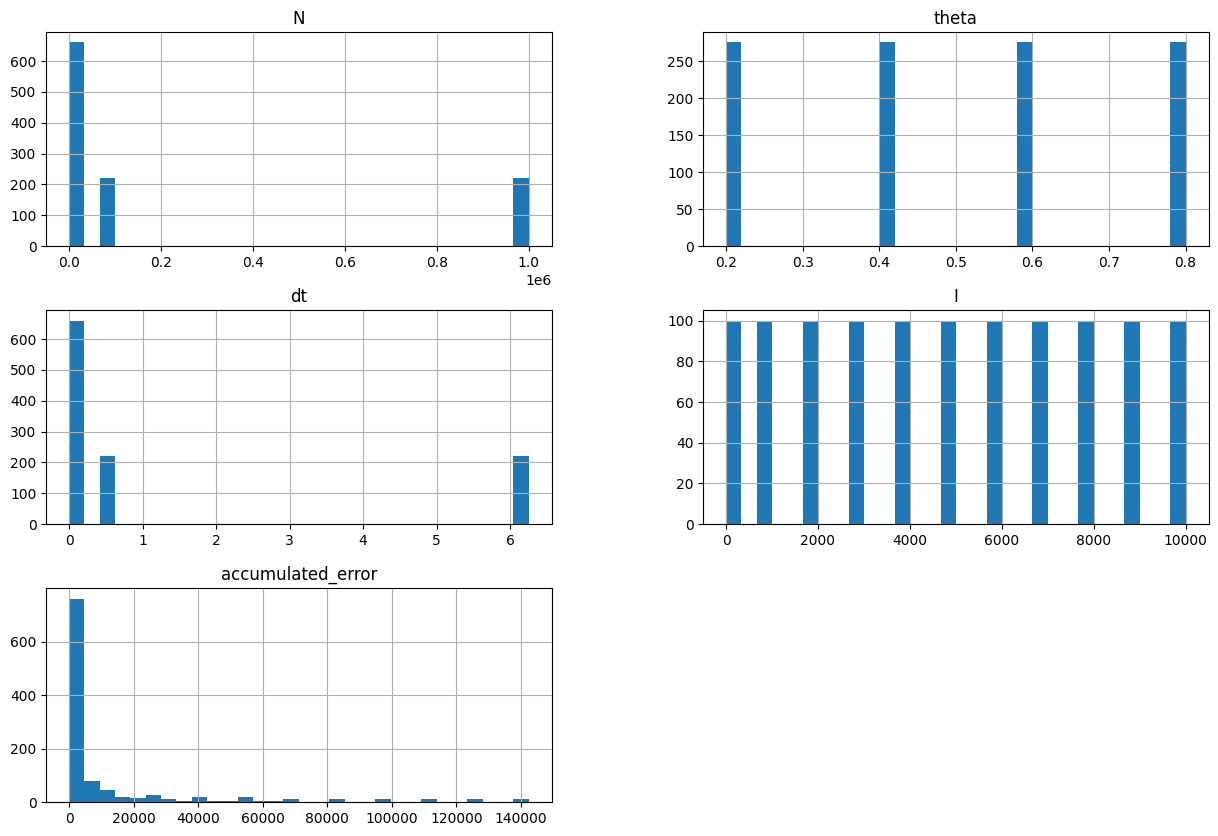

In [9]:
import matplotlib.pyplot as plt
sampled_err_df.hist(bins=30, figsize=(15, 10))
plt.show()

## Error Tests

### Test 1: train test split base (mae)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import HuberRegressor

# Features and target
X = full_err_df[['N', 'theta', 'dt', 'I']]
y = full_err_df['accumulated_error']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model: Random Forest Regressor
# model = RandomForestRegressor(n_estimators=100, random_state=42)
model = HuberRegressor()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.6f}")

# Example Prediction for an arbitrary input
example_input = {'N': 100, 'theta': 0.2, 'dt': 6.25e-05, 'I': 5000}
example_scaled = scaler.transform(pd.DataFrame([example_input]))
predicted_error = model.predict(example_scaled)
print(f"Predicted Accumulated Energy Error: {predicted_error[0]:.6f}")

Mean Absolute Error: 8183.134219
Predicted Accumulated Energy Error: -779.361373


### Test 2: Feature subset CV starting tests

In [ ]:
from sklearn.linear_model import HuberRegressor

# Define dataset and parameters
input_features = ['N', 'theta', 'dt', 'I']
target_feature = 'accumulated_error'

# Define the model pipeline
pipeline = Pipeline(steps=[
    # ('normalize', QuantileTransformer()),
    ('model', HuberRegressor())
])

# Wrap with TransformedTargetRegressor
model = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=FunctionTransformer(lambda x:x)
)

# Define hyperparameter grid
model_params = {
    'regressor__model__epsilon': [1.35, 1.5, 1.75],
    'regressor__model__alpha': [0.0001, 0.001, 0.01],
}

# Run feature subset evaluation using Random CV
best_result_hr, res_hr = run_feature_subset_cv(
    f_full=full_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model,
    model_params=model_params,
    use_feature_subsets=False,
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_hr['features'])
print("Best parameters:", best_result_hr['best_params'])
print("Best MAE:", best_result_hr['best_mae'])
print("Best MAPE:", best_result_hr['best_mape'])

# # Run feature subset evaluation using GPU split CV
# best_result_hr, res_hr = run_feature_subset_cv(
#     f_full=f_full,
#     input_features=input_features,
#     target_feature=target_feature,
#     model=model,
#     model_params=model_params,
#     use_feature_subsets=True,
#     use_gpu_cv=True  # Set to False to use regular KFold
# )

# # Display the best result
# print("Best feature subset:", best_result_hr['features'])
# print("Best parameters:", best_result_hr['best_params'])
# print("Best MAE:", best_result_hr['best_mae'])
# print("Best MAPE:", best_result_hr['best_mape'])


### Test 3: Feature subset CV with sampling (mae)

In [ ]:
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures

base_model_poly = Pipeline([
                    ('poly', PolynomialFeatures(5)),   # PolynomialFeatures step
                    ('ridge', Ridge())                # Ridge regression step
                ])

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import HuberRegressor

# Features and target
X = sampled_err_df[['N', 'theta', 'dt', 'I']]
y = sampled_err_df['accumulated_error']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Feature scaling
scaler = FunctionTransformer(lambda x:x**1/10)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model: Random Forest Regressor
# model = RandomForestRegressor(n_estimators=100, random_state=42)
model = base_model_poly
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.6f}")

# Example Prediction for an arbitrary input
example_input = {'N': 1000000, 'theta': 0.2, 'dt': 0.00625, 'I': 5000}
example_scaled = scaler.transform(pd.DataFrame([example_input]))
predicted_error = model.predict(example_scaled)
print(f"Predicted Accumulated Energy Error: {predicted_error[0]:.6f}")

# Cross validation training

### Transformers

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import matplotlib.pyplot as plt

# Define named functions for the transformations
def log10_transform(x):
    return np.log10(x)

def inverse_log10_transform(x):
    return np.power(10, x)

# Define named functions for the transformations
def log2_transform(x):
    return np.log2(x)

def inverse_log2_transform(x):
    return np.power(2, x)

# Define the sequential transformer 
log10_scale_transformer = Pipeline(steps=[
    ('log10', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform)),  # Apply log10
    ('scaler', StandardScaler()), 
])

# Define the sequential transformer 
log_scale_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(func=np.log, inverse_func=np.exp)),  # Apply log10
    ('scaler', StandardScaler()), 
])

### Pipeline generator (scaled and transformed)

In [7]:
# 'Clock Rate (MHz)' StandardScaler probs
# 'Multiprocessors (SMs)' StandardScaler
# 'Half Precision FLOP/s', StandardScaler
# 'Single Precision FLOP/s', StandardScaler
# 'Double Precision FLOP/s', StandardScaler
# 'gld_transactions (dev_approximate_gravity)', log10_scale_transformer
# 'thread_inst_executed (dev_approximate_gravity)', log10_scale_transformer
# 'inst_compute_ld_st (correct_particles)', log10_scale_transformer
# 'active_warps_pm (correct_particles)', log10_scale_transformer
# 'global_store_requests (correct_particles)' log10_scale_transformer
# 'exec_time_avg' log10_scale_transformer

from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer

# Define the transformer for N and theta columns
def CreatePipelineModel(model,input_parameters):
    
    # Apply defined transforms available input columns columns
    transformer = ColumnTransformer(
        transformers=[
            ('scale', StandardScaler(), list(set(input_parameters) & set(['theta','Clock Rate (MHz)','Multiprocessors (SMs)','L2 Cache Size (KB)',
                                                                          'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s']))),
            ('log10', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform),list(set(input_parameters) & set(['I']))),  # Apply log10
            ('log', FunctionTransformer(func=np.log, inverse_func=np.exp), list(set(input_parameters) & set(['dt']))),
            ('log10scale', log10_scale_transformer, list(set(input_parameters) & set(   ['N','gld_transactions (dev_approximate_gravity)',
                                                                                        'thread_inst_executed (dev_approximate_gravity)',
                                                                                        'inst_compute_ld_st (correct_particles)', 
                                                                                        'active_warps_pm (correct_particles)',
                                                                                        'global_store_requests (correct_particles)'])))
        ],
        remainder='passthrough'  # Pass through the remaining columns as they are
    )

    # Define the model pipeline
    pipeline = Pipeline(steps=[
        ('normalize', transformer), 
        ('model', model) 
    ])

    # Wrap with TransformedTargetRegressor
    pipelined_model = TransformedTargetRegressor(
        regressor=pipeline, 
        transformer=log_scale_transformer
    )

    return pipelined_model

### Wrapped Cross Validation Grid Search Trainer

In [8]:
from numpy import mean, absolute
from itertools import combinations
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV,TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter
from IPython.display import clear_output
import os

def run_feature_subset_cv(
    f_full, 
    input_features, 
    target_feature, 
    model, 
    model_params, 
    extra_features=[], 
    use_ts_cv=False,
    use_feature_subsets=True, 
    refit_error='MAPE', #MAPE OR MAE
    output_folder="CV_results"
):
    f_full = f_full.reset_index(drop=True)
    # Prepare input and target
    X_full = f_full[input_features+extra_features]
    y = f_full[target_feature]

    # Generate feature subsets or use all features
    if use_feature_subsets:
        feature_subsets = []
        for r in range(1, len(X_full[input_features].columns) + 1):  # r = subset size (1 to len(columns))
            feature_subsets.extend(combinations(X_full[input_features].columns, r))
    else:
        feature_subsets = [input_features]  # Use all input features as one subset
    
    # Define cross-validation strategy
    if use_ts_cv:
        unique_I_values = f_full['I'].unique()
        unique_I_values.sort()
        n_splits = 5  # Number of splits for TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=n_splits)
        custom_splits = []

        for train_index, test_index in tscv.split(unique_I_values):
            train_I_values = unique_I_values[train_index]
            test_I_values = unique_I_values[test_index]
            train_indices = f_full[f_full['I'].isin(train_I_values)].index
            test_indices = f_full[f_full['I'].isin(test_I_values)].index
            custom_splits.append((train_indices, test_indices))
        cv = custom_splits
    else:
        cv = KFold(n_splits=10, shuffle=True, random_state=1)

    # Define scoring metrics
    scorer_mae = make_scorer(mean_absolute_error, greater_is_better=False)
    scorer_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

    # Store results
    results = []
    
    # Precompute the pipeline models
    precomputed_models = [
        CreatePipelineModel(input_parameters=list(features) + extra_features, model=model)
        for features in feature_subsets
    ]

    print(f"Testing {len(feature_subsets)} feature subset(s)...")
    with tqdm(total=len(feature_subsets), desc="Progress", unit="subset") as pbar, \
         tqdm(total=len(feature_subsets), desc="Custom Text", unit="update") as text_pbar:
                # Iterate over feature subsets
        for idx, features in enumerate(feature_subsets):
            # Subset the input data
            X = X_full[list(features)+extra_features]

            # Access the precomputed pipeline model by index
            pipelined_model = precomputed_models[idx]

            # Create GridSearchCV object
            grid_search = GridSearchCV(
                estimator=pipelined_model,
                param_grid=model_params,
                scoring={'MAE': scorer_mae, 'MAPE': scorer_mape},
                refit=refit_error,  # Optimize based on MAPE
                cv=cv,
                verbose=0,
                n_jobs=20 # -1  # Use all available cores
            )

            # Fit GridSearchCV
            grid_search.fit(X, y)

            # Append results
            results.append({
                'features': list(features)+extra_features,
                'best_params': grid_search.best_params_,
                'best_mae': -grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_],
                'best_mape': -grid_search.cv_results_['mean_test_MAPE'][grid_search.best_index_]
            })
            
            pbar.set_postfix({"current_subset": str(list(features)+extra_features), "current_mae": round(results[-1]['best_mae'], 3),"current_mape": round(results[-1]['best_mape'], 3)})
            text_pbar.set_description_str(
                f"> best_mae:{round(min(results, key=lambda x: x['best_mae'])['best_mae'], 3)}\n"+
                f"> best_mape:{round(min(results, key=lambda x: x['best_mape'])['best_mape'], 3)}\n"+
                f"> best_params:{min(results, key=lambda x: x['best_mape'])['best_params']}\n"+
                f"> best_features:{min(results, key=lambda x: x['best_mape'])['features']}")
            pbar.update(1)
            text_pbar.update(1)

    # Find the best result
    best_result = min(results, key=lambda x: x['best_mape'])
    
    # Extract the model name from the pipeline
    model_name = pipelined_model.regressor.steps[-1][1].__class__.__name__

    # Determine CV type for the filename
    cv_type = "TS_CV" if use_ts_cv else "Random_CV"

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Construct the base filename
    base_filename = f"{model_name}_{cv_type}_results"
    output_path = os.path.join(output_folder, f"{base_filename}.json")

    # If a file with the same name exists, append a number
    counter = 1
    while os.path.exists(output_path):
        output_path = os.path.join(output_folder, f"{base_filename}_{counter}.json")
        counter += 1

    # Include best result in the JSON data
    output_data = {
        "all_results": results,
        "best_result": best_result
    }

    # Write results to a JSON file
    with open(output_path, 'w') as json_file:
        json.dump(output_data, json_file, indent=4, default=str)  # Use default=str for non-serializable data

    print(f"Results saved to {output_path}")
    
    return best_result,results

### Huber tests

```py
Results saved to CV_results/error2/HuberRegressor_Random_CV_results_1.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__alpha': 1e-05, 'regressor__model__epsilon': 5}
Best MAE: 53985.00300321941
Best MAPE: 5.438605401036232

Results saved to CV_results/error2/HuberRegressor_TS_CV_results_2.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__alpha': 1, 'regressor__model__epsilon': 5}
Best MAE: 128465.9529811915
Best MAPE: 3.1336773373095164
```

In [10]:
from sklearn.linear_model import HuberRegressor

# Define hyperparameter grid
model_params_huber = {
    'regressor__model__epsilon': [1, 1.35, 1.5, 1.75, 2, 5],
    'regressor__model__alpha': [0.00001,0.0001, 0.001, 0.01,0.1,1],
}

In [220]:
# Run feature subset evaluation using Random CV
best_result_huber, res_huber = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=HuberRegressor(max_iter=1000),
    model_params=model_params_huber,
    output_folder="CV_results/error2",
    use_feature_subsets=False,
    use_ts_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_huber['features'])
print("Best parameters:", best_result_huber['best_params'])
print("Best MAE:", best_result_huber['best_mae'])
print("Best MAPE:", best_result_huber['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error2/HuberRegressor_Random_CV_results_3.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__alpha': 1e-05, 'regressor__model__epsilon': 5}
Best MAE: 53985.00300321941
Best MAPE: 5.438605401036232


In [11]:
# Run feature subset evaluation using Random CV
best_result_huber, res_huber = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=HuberRegressor(max_iter=1000),
    model_params=model_params_huber,
    output_folder="CV_results/error2",
    use_feature_subsets=False,
    use_ts_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_huber['features'])
print("Best parameters:", best_result_huber['best_params'])
print("Best MAE:", best_result_huber['best_mae'])
print("Best MAPE:", best_result_huber['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error2/HuberRegressor_TS_CV_results_2.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__alpha': 1, 'regressor__model__epsilon': 5}
Best MAE: 128465.9529811915
Best MAPE: 3.1336773373095164


### SVR tests

```py
Results saved to CV_results/error2/SVR_Random_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__C': 1000, 'regressor__model__epsilon': 0.0001, 'regressor__model__kernel': 'rbf'}
Best MAE: 680.6296667114714
Best MAPE: 0.23997116369975444

Results saved to CV_results/error2/SVR_TS_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__C': 2000, 'regressor__model__epsilon': 0.001, 'regressor__model__kernel': 'rbf'}
Best MAE: 1077.8871439806637
Best MAPE: 0.12457961222928701
```

In [13]:
from sklearn.svm import SVR, LinearSVR

# Define hyperparameter grid
model_params_svr = {
    'regressor__model__C': [0.0001,0.001, 0.01, 0.1, 1, 10, 50,100,1000, 2000], 
    'regressor__model__epsilon': [0.00001,0.0001, 0.001, 0.01, 0.1, 0.5, 1], 
    'regressor__model__kernel': ['rbf']
}

In [143]:
# Run feature subset evaluation using Random CV
best_result_svr, res_svr = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=SVR(),
    model_params=model_params_svr,
    output_folder="CV_results/error2",
    use_feature_subsets=False,
    use_ts_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_svr['features'])
print("Best parameters:", best_result_svr['best_params'])
print("Best MAE:", best_result_svr['best_mae'])
print("Best MAPE:", best_result_svr['best_mape'])


Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error2/SVR_Random_CV_results_1.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__C': 2000, 'regressor__model__epsilon': 0.0001, 'regressor__model__kernel': 'rbf'}
Best MAE: 655.6105086352038
Best MAPE: 0.2446838058449455


In [14]:
# Run feature subset evaluation using Random CV
best_result_svr, res_svr = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=SVR(),
    model_params=model_params_svr,
    output_folder="CV_results/error2",
    use_feature_subsets=False,
    use_ts_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_svr['features'])
print("Best parameters:", best_result_svr['best_params'])
print("Best MAE:", best_result_svr['best_mae'])
print("Best MAPE:", best_result_svr['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error2/SVR_TS_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__C': 2000, 'regressor__model__epsilon': 0.001, 'regressor__model__kernel': 'rbf'}
Best MAE: 1077.8871439806637
Best MAPE: 0.12457961222928701


### DT tests

```py
Results saved to CV_results/error2/DecisionTreeRegressor_Random_CV_results_3.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2}
Best MAE: 369.6076315937861
Best MAPE: 0.46763542927434515

Results saved to CV_results/error2/DecisionTreeRegressor_TS_CV_results_2.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 0.2, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2}
Best MAE: 3031.1517187329127
Best MAPE: 0.17553332927189597
```

In [16]:
from sklearn.tree import DecisionTreeRegressor

# Define hyperparameter grid
model_params_dt = {
    'regressor__model__max_depth': [2,5,10, 20, None],
    'regressor__model__min_samples_split': [2, 5, 10],
    'regressor__model__min_samples_leaf': [1, 2, 4],
    'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0]
}

In [114]:
# Run feature subset evaluation using Random CV
best_result_dt, res_dt = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=DecisionTreeRegressor(random_state=42), 
    model_params=model_params_dt,
    output_folder="CV_results/error2",
    use_feature_subsets=False,
    use_ts_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_dt['features'])
print("Best parameters:", best_result_dt['best_params'])
print("Best MAE:", best_result_dt['best_mae'])
print("Best MAPE:", best_result_dt['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error2/DecisionTreeRegressor_Random_CV_results_5.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2}
Best MAE: 369.6076315937861
Best MAPE: 0.46763542927434515


In [19]:
# Run feature subset evaluation using Random CV
best_result_dt, res_dt = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=DecisionTreeRegressor(random_state=42),
    model_params=model_params_dt,
    output_folder="CV_results/error2",
    use_feature_subsets=False,
    use_ts_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_dt['features'])
print("Best parameters:", best_result_dt['best_params'])
print("Best MAE:", best_result_dt['best_mae'])
print("Best MAPE:", best_result_dt['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error2/DecisionTreeRegressor_TS_CV_results_2.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 0.2, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2}
Best MAE: 3031.1517187329127
Best MAPE: 0.17553332927189597


### ERT tests

```py
Results saved to CV_results/error2/ExtraTreesRegressor_Random_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2, 'regressor__model__n_estimators': 200}
Best MAE: 349.8206215034054
Best MAPE: 0.261127532539839

Results saved to CV_results/error2/ExtraTreesRegressor_TS_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 0.2, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2, 'regressor__model__n_estimators': 500}
Best MAE: 3031.15171873294
Best MAPE: 0.17553332927189438
```

In [20]:
from sklearn.ensemble import ExtraTreesRegressor

# Define hyperparameter grid
model_params_ert = {
    'regressor__model__n_estimators': [50, 100, 200, 300, 500],        # Number of trees in the forest
    'regressor__model__max_depth': [10, 20, 30, None],
    'regressor__model__min_samples_split': [2, 5, 10],
    'regressor__model__min_samples_leaf': [1, 2, 4],
    'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
}

In [116]:
# Run feature subset evaluation using Random CV
best_result_ert, res_ert = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=ExtraTreesRegressor(random_state=42),
    model_params=model_params_ert,
    output_folder="CV_results/error2",
    use_feature_subsets=False,
    use_ts_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_ert['features'])
print("Best parameters:", best_result_ert['best_params'])
print("Best MAE:", best_result_ert['best_mae'])
print("Best MAPE:", best_result_ert['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error2/ExtraTreesRegressor_Random_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2, 'regressor__model__n_estimators': 200}
Best MAE: 349.8206215034054
Best MAPE: 0.261127532539839


In [21]:
# Run feature subset evaluation using Random CV
best_result_ert, res_ert = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=ExtraTreesRegressor(random_state=42),
    model_params=model_params_ert,
    output_folder="CV_results/error2",
    use_feature_subsets=False,
    use_ts_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_ert['features'])
print("Best parameters:", best_result_ert['best_params'])
print("Best MAE:", best_result_ert['best_mae'])
print("Best MAPE:", best_result_ert['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error2/ExtraTreesRegressor_TS_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 0.2, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2, 'regressor__model__n_estimators': 500}
Best MAE: 3031.15171873294
Best MAPE: 0.17553332927189438


### Poly ridge tests

```py
Results saved to CV_results/error2/Pipeline_Random_CV_results_4.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__poly__degree': 5, 'regressor__model__ridge__alpha': 0.0001}
Best MAE: 2051.367088915304
Best MAPE: 0.3849981900124745

Results saved to CV_results/error2/Pipeline_TS_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__poly__degree': 7, 'regressor__model__ridge__alpha': 0.01}
Best MAE: 1826.337786294854
Best MAPE: 0.10749104047552309
```

In [22]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

# Define hyperparameter grid
model_params_poly = {
    'regressor__model__poly__degree': [2, 3, 4, 5, 6, 7], 
    'regressor__model__ridge__alpha': [0.0001, 0.001, 0.01, 0.1],
}

# Define the model pipeline
Poly = Pipeline(steps=[
    ('ridge_scale', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('ridge', Ridge(random_state=42))
])

In [128]:
# Run feature subset evaluation using Random CV
best_result_poly, res_poly = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=Poly,
    model_params=model_params_poly,
    output_folder="CV_results/error2",
    use_feature_subsets=False,
    use_ts_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_poly['features'])
print("Best parameters:", best_result_poly['best_params'])
print("Best MAE:", best_result_poly['best_mae'])
print("Best MAPE:", best_result_poly['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error2/Pipeline_Random_CV_results_4.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__poly__degree': 5, 'regressor__model__ridge__alpha': 0.0001}
Best MAE: 2051.367088915304
Best MAPE: 0.3849981900124745


In [23]:
# Run feature subset evaluation using Random CV
best_result_poly, res_poly = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=Poly,
    model_params=model_params_poly,
    output_folder="CV_results/error2",
    use_feature_subsets=False,
    use_ts_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_poly['features'])
print("Best parameters:", best_result_poly['best_params'])
print("Best MAE:", best_result_poly['best_mae'])
print("Best MAPE:", best_result_poly['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error2/Pipeline_TS_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__poly__degree': 7, 'regressor__model__ridge__alpha': 0.01}
Best MAE: 1826.337786294854
Best MAPE: 0.10749104047552309


/home/home-server/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## Final models train and export

### Best parameter loader function

In [26]:
import json

def load_best_params_and_features(json_filename):
    try:
        # Load the JSON file
        with open(json_filename, 'r') as file:
            data = json.load(file)

        # Extract the best parameters
        best_params = data.get("best_result", {}).get("best_params", {})
        if not best_params:
            raise ValueError("No 'best_params' found in the JSON file.")

        # Extract the selected features
        selected_features = data.get("best_result", {}).get("features", [])
        if not selected_features:
            raise ValueError("No 'features' found in the JSON file.")

        # Simplify parameters to only values (not lists)
        simplified_params = {key: value[0] if isinstance(value, list) else value for key, value in best_params.items()}

        print("Loaded best parameters and selected features:")
        print("Best Parameters:", simplified_params)
        print("Selected Features:", selected_features)
        return simplified_params, selected_features

    except FileNotFoundError:
        print(f"Error: File not found - {json_filename}")
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON file - {json_filename}")
    except ValueError as ve:
        print(f"Error: {ve}")


### Export model to file

In [134]:
import joblib

def export_model(model, filename):
    try:
        # Save the model to the specified file
        joblib.dump(model, filename,compress=1)
        print(f"Model exported successfully to: {filename}")
    except Exception as e:
        print(f"Error exporting model: {e}")


### Huber export

In [135]:
model_params, selected_features = load_best_params_and_features("CV_results/error2/HuberRegressor_Random_CV_results_1.json")

model_huber_final = CreatePipelineModel(input_parameters=selected_features,model=HuberRegressor(max_iter=1000))

X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_huber_final.set_params(**model_params)

model_huber_final.fit(X, y)

display(model_huber_final)

# Export
export_model(model_huber_final, "Models/Precision/model_huber_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__alpha': 1e-05, 'regressor__model__epsilon': 5}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['theta']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x73b59af817e0>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x73b59af81900>),
                                                                                       ['I']),
                                                                                      ('log',
                                                                                       FunctionTransformer(func=<ufunc 'log'>...
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x73b59af817e0>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x73b59af81900>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      HuberRegressor(alpha=1e-05,
                                                                     epsilon=5,
                                                                     max_iter=1000))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Precision/model_huber_final.joblib


### SVR export

In [145]:
model_params, selected_features = load_best_params_and_features("CV_results/error2/SVR_Random_CV_results.json")

model_svr_final = CreatePipelineModel(input_parameters=selected_features,model=SVR())

X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_svr_final.set_params(**model_params)

model_svr_final.fit(X, y)

display(model_svr_final)

# Export
export_model(model_svr_final, "Models/Precision/model_svr_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__C': 1000, 'regressor__model__epsilon': 0.0001, 'regressor__model__kernel': 'rbf'}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['theta']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x73b59af817e0>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x73b59af81900>),
                                                                                       ['I']),
                                                                                      ('log',
                                                                                       FunctionTransformer(func=<ufunc 'log'>...
                                                                                       Pipeline(steps=[('log10',
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x73b59af817e0>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x73b59af81900>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      SVR(C=1000,
                                                          epsilon=0.0001))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Precision/model_svr_final.joblib


### DT export

In [138]:
model_params, selected_features = load_best_params_and_features("CV_results/error2/DecisionTreeRegressor_Random_CV_results_3.json")

model_dt_final = CreatePipelineModel(input_parameters=selected_features,model=DecisionTreeRegressor(random_state=42))

X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_dt_final.set_params(**model_params)

model_dt_final.fit(X, y)

display(model_dt_final)

# Export
export_model(model_dt_final, "Models/Precision/model_dt_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['theta']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x73b59af817e0>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x73b59af81900>),
                                                                                       ['I']),
                                                                                      ('log',
                                                                                       FunctionTransformer(func=<ufunc 'log'>...
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x73b59af817e0>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x73b59af81900>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      DecisionTreeRegressor(max_depth=20,
                                                                            max_features=1.0,
                                                                            random_state=42))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Precision/model_dt_final.joblib


### ERT export

In [139]:
model_params, selected_features = load_best_params_and_features("CV_results/error2/ExtraTreesRegressor_Random_CV_results.json")

model_ert_final = CreatePipelineModel(input_parameters=selected_features,model=ExtraTreesRegressor(random_state=42))

X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_ert_final.set_params(**model_params)

model_ert_final.fit(X, y)

display(model_ert_final)

# Export
export_model(model_ert_final, "Models/Precision/model_ert_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2, 'regressor__model__n_estimators': 200}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['theta']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x73b59af817e0>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x73b59af81900>),
                                                                                       ['I']),
                                                                                      ('log',
                                                                                       FunctionTransformer(func=<ufunc 'log'>...
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x73b59af817e0>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x73b59af81900>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      ExtraTreesRegressor(max_depth=20,
                                                                          n_estimators=200,
                                                                          random_state=42))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Precision/model_ert_final.joblib


### Poly ridge export

In [141]:
model_params, selected_features = load_best_params_and_features("CV_results/error2/Pipeline_Random_CV_results_4.json")

model_poly_final = CreatePipelineModel(input_parameters=selected_features,model=Poly)

X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_poly_final.set_params(**model_params)

model_poly_final.fit(X, y)

display(model_poly_final)

# Export
export_model(model_poly_final, "Models/Precision/model_poly_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__poly__degree': 5, 'regressor__model__ridge__alpha': 0.0001}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['theta']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x73b59af817e0>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x73b59af81900>),
                                                                                       ['I']),
                                                                                      ('log',
                                                                                       FunctionTransformer(func=<ufunc 'log'>...
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x73b59af81900>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      Pipeline(steps=[('ridge_scale',
                                                                       StandardScaler()),
                                                                      ('poly',
                                                                       PolynomialFeatures(degree=5)),
                                                                      ('ridge',
                                                                       Ridge(alpha=0.0001,
                                                                             random_state=42))]))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Precision/model_poly_final.joblib


## TS CV Details

### Per timesplit error calculation

In [24]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

def per_ts_errors(f_full, model_used, model_result, ts_feature='I', target_feature='accumulated_error'):

    f_full = f_full.reset_index(drop=True)
    
    model_params, selected_features = load_best_params_and_features(model_result)

    model_ert_final = CreatePipelineModel(input_parameters=selected_features, model=model_used) 

    X, y = f_full[selected_features], f_full[target_feature]

    # Define custom cross-validation strategy based on 'I'
    unique_I_values = f_full['I'].unique()
    unique_I_values.sort()
    n_splits = 5  # Number of splits for TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    custom_splits = []

    for train_index, test_index in tscv.split(unique_I_values):
        train_I_values = unique_I_values[train_index]
        test_I_values = unique_I_values[test_index]
        train_indices = f_full[f_full['I'].isin(train_I_values)].index
        test_indices = f_full[f_full['I'].isin(test_I_values)].index
        custom_splits.append((train_indices, test_indices))

    # Store the MAPE and MAE scores for each fold along with group names
    fold_scores = []
    group_names = []

    # Loop through each fold, get the groups and MAPE score
    for train_indices, test_indices in custom_splits:
        # Get group names for the test set in this fold
        test_group_names = f_full.iloc[test_indices][ts_feature].unique()
        group_names.append(test_group_names)
        model_ert_final.set_params(**model_params)
        
        # Train on the best model and compute the score for this fold
        model_ert_final.fit(X.iloc[train_indices], y.iloc[train_indices])
        y_pred = model_ert_final.predict(X.iloc[test_indices])
        fold_mape = mean_absolute_percentage_error(y.iloc[test_indices], y_pred)
        fold_mae = mean_absolute_error(y.iloc[test_indices], y_pred)

        # Store the score
        fold_scores.append({"mape": fold_mape, "mae": fold_mae})

    # Print results with group names
    for fold_idx, (score, group) in enumerate(zip(fold_scores, group_names), start=1):
        print(f"Fold {fold_idx} (Groups: {group}): MAPE = {score['mape']:.4f}, MAE = {score['mae']:.4f}")

    mean_mape = np.mean([score['mape'] for score in fold_scores])
    mean_mae = np.mean([score['mae'] for score in fold_scores])
    print(f"Mean MAE across all folds: {mean_mae:.4f}")
    print(f"Mean MAPE across all folds: {mean_mape:.4f}")

    return fold_scores, group_names

### Models

In [28]:
print("Huber:")
_,_ = per_ts_errors(sampled_err_df, HuberRegressor(max_iter=1000), "CV_results/error2/HuberRegressor_TS_CV_results_2.json")
print("SVR:")
_,_ = per_ts_errors(sampled_err_df, SVR(), "CV_results/error2/SVR_TS_CV_results.json")
print("DecisionTree:")
_,_ = per_ts_errors(sampled_err_df, DecisionTreeRegressor(random_state=42), "CV_results/error2/DecisionTreeRegressor_TS_CV_results_2.json")
print("ExtraTrees:")
_,_ = per_ts_errors(sampled_err_df, ExtraTreesRegressor(random_state=42), "CV_results/error2/ExtraTreesRegressor_TS_CV_results.json")
print("Poly:")
_,_ = per_ts_errors(sampled_err_df, Poly, "CV_results/error2/Pipeline_TS_CV_results.json")

Huber:
Loaded best parameters and selected features:
Best Parameters: {'regressor__model__alpha': 1, 'regressor__model__epsilon': 5}
Selected Features: ['N', 'theta', 'dt', 'I']
Fold 1 (Groups: [6000]): MAPE = 3.3354, MAE = 100788.7628
Fold 2 (Groups: [7000]): MAPE = 3.1714, MAE = 114740.8302
Fold 3 (Groups: [8000]): MAPE = 3.0844, MAE = 128589.7154
Fold 4 (Groups: [9000]): MAPE = 3.0475, MAE = 142311.9687
Fold 5 (Groups: [10000]): MAPE = 3.0297, MAE = 155898.4877
Mean MAE across all folds: 128465.9530
Mean MAPE across all folds: 3.1337
SVR:
Loaded best parameters and selected features:
Best Parameters: {'regressor__model__C': 2000, 'regressor__model__epsilon': 0.001, 'regressor__model__kernel': 'rbf'}
Selected Features: ['N', 'theta', 'dt', 'I']
Fold 1 (Groups: [6000]): MAPE = 0.1791, MAE = 817.9054
Fold 2 (Groups: [7000]): MAPE = 0.1355, MAE = 939.1296
Fold 3 (Groups: [8000]): MAPE = 0.1138, MAE = 1102.1474
Fold 4 (Groups: [9000]): MAPE = 0.1020, MAE = 1224.1371
Fold 5 (Groups: [1000

## Tests

### direct test

In [26]:
model_gb_final.predict([[100000,0.2,0.0625, 10000]])

NameError: name 'model_gb_final' is not defined

### compare against model

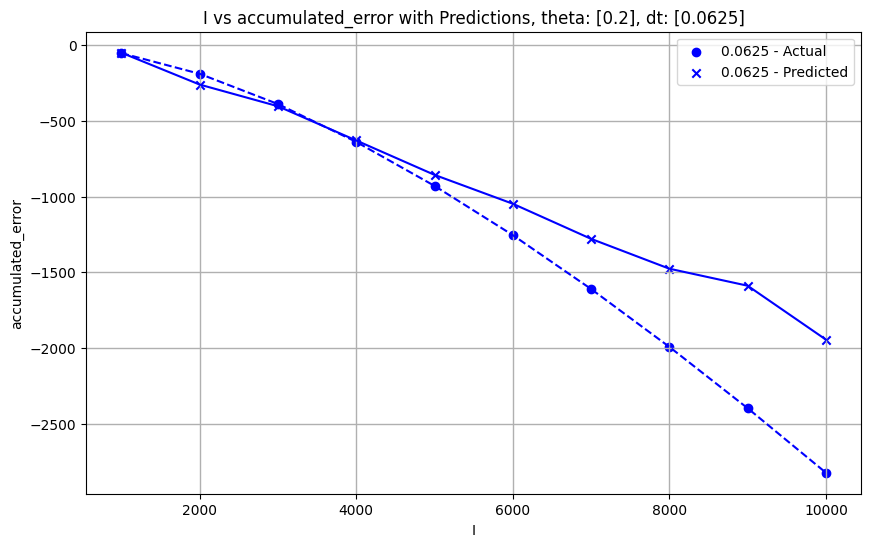

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df = sampled_err_df.copy()
model = model_poly_final

# Define the filter criteria
filter_criteria = {
    'theta': [0.2],
    'N': [100000],
    # 'I': [10000],
    'dt': [0.0625]
}

# Apply filtering based on the filter criteria
for feature, values in filter_criteria.items():
    df = df[df[feature].isin(values)]

# Add predictions to the filtered dataset
df['predicted_accumulated_error'] = model.predict(df[['N', 'theta', 'dt', 'I']])

# Group by a specific feature
grouped = df.groupby('dt')

# Plot X vs y for each group
colors = ['blue', 'green', 'red', 'purple', 'yellow']  # Specify colors for each group if known

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot X vs y with scatter points and connect them with dashed lines for each group
for (group_name, group_data), color in zip(grouped, colors):
    # Plot actual values
    ax.scatter(group_data['I'], group_data['accumulated_error'], color=color, label=f'{group_name} - Actual')
    ax.plot(group_data['I'], group_data['accumulated_error'], linestyle='--', color=color)  # Dashed line for actual
    
    # Plot predicted values
    ax.scatter(group_data['I'], group_data['predicted_accumulated_error'], color=color, marker='x', label=f'{group_name} - Predicted')
    ax.plot(group_data['I'], group_data['predicted_accumulated_error'], linestyle='-', color=color)  # Solid line for predicted

# Add grid and logarithmic scales
ax.grid(linestyle='-', linewidth=1)
# ax.set_yscale("asinh")         # Logarithmic scale for y-axis

# Add labels, title, and legend
ax.set_xlabel('I')
ax.set_ylabel('accumulated_error')
ax.set_title('I vs accumulated_error with Predictions, theta: [0.2], dt: [0.0625]')
ax.legend()

# Set x and y limits to cover the range of points
# ax.set_xlim(df['I'].min() - 1, df['I'].max() + 1)
# ax.set_ylim(df['accumulated_error'].min() * 0.8, df['accumulated_error'].max() * 1.2)

plt.show()

# COMPARAR CON: https://top500.org/system/179842/


EXPORT LIMITED: .query('I <= 4000') 